In [9]:
import numpy as np
import pandas as pd
import sklearn
import pickle

import matplotlib.pyplot as plt
import cv2

In [10]:
# Load all models
haar = cv2.CascadeClassifier('./model/haarcascade_frontalface_default.xml')
model_svm = pickle.load(open('./model/model_svm.pickle', mode='rb'))
pca_models = pickle.load(open('./model/pca_dict.pickle', mode='rb'))


In [13]:
model_pca = pca_models['pca']
mean_face_arr = pca_models['mean_face']

## Create Pipeline

In [58]:
# 1.  read image
img = cv2.imread('./test_images/test_04.png')
# 2. convert into gray scale
gray =  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# 3. crop the face (using haar)
faces = haar.detectMultiScale(gray, 1.5, 5)
predictions = []

for x, y, w, h in faces:
    roi = gray[y:y+h, x:x+w]
    # 4. normalization (0-1)
    roi = roi / 255.0
    # 5. resize images (100,100)
    if roi.shape[1] > 100:
        roi_resize = cv2.resize(roi, (100, 100), cv2.INTER_AREA)
    else:
        roi_resize = cv2.resize(roi, (100, 100), cv2.INTER_CUBIC)
    # 6. flattening (1X1000)
    roi_resize = roi_resize.reshape(1, 10000)    
    # 7. subtract with mean
    roi_mean = roi_resize - mean_face_arr
    # 8. get eigen image (apply roi_mean to PCA)
    eigen_image = model_pca.transform(roi_mean)
    # 9. eigen image visualization
    eigen_img = model_pca.inverse_transform(eigen_image)
    # 10. pass to ml model and get predictions
    result = model_svm.predict(eigen_image)
    prob_score = model_svm.predict_proba(eigen_image)
    prob_score_max = prob_score.max().round(2)
    # 11. generate report
    text = f"{result[0]} : {prob_score_max * 100}"
    
    # 12. defining color based on results
    if result[0] == 'male':
        color = (255, 255, 0)
    else:
        color = (255, 0, 255)
    
    cv2.rectangle(img, (x,y), (x+w, y+h), color,2)
    cv2.rectangle(img, (x,y-30), (x+w, y), color,-1)
    cv2.putText(img, text, (x,y), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), 5)
    
    output = {
        'roi': roi,
        'eig_img': eigen_img,
        'prediction_name': result[0],
        'score': prob_score_max
    }
    predictions.append(output)

In [59]:
predictions

[{'roi': array([[0.28235294, 0.28235294, 0.28235294, ..., 0.29019608, 0.29411765,
          0.29019608],
         [0.27058824, 0.2745098 , 0.2745098 , ..., 0.27843137, 0.27843137,
          0.27843137],
         [0.2627451 , 0.26666667, 0.2627451 , ..., 0.26666667, 0.26666667,
          0.26666667],
         ...,
         [0.99607843, 0.99607843, 0.99607843, ..., 1.        , 1.        ,
          1.        ],
         [0.99607843, 0.99607843, 0.99607843, ..., 1.        , 1.        ,
          1.        ],
         [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
          0.99607843]], shape=(182, 182)),
  'eig_img': array([[-0.17816542, -0.1798155 , -0.17368538, ...,  0.56750996,
           0.5709183 ,  0.57151711]], shape=(1, 10000)),
  'prediction_name': 'male',
  'score': np.float64(0.89)},
 {'roi': array([[0.29019608, 0.28235294, 0.28627451, ..., 0.29803922, 0.30196078,
          0.30196078],
         [0.28627451, 0.28627451, 0.28235294, ..., 0.30588235, 0.3058823

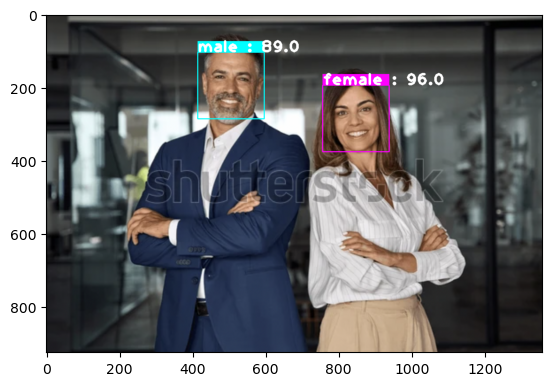

In [57]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)